In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.7.6
IPython 7.13.0

numpy 1.18.1
pandas 0.23.4
torch 1.4.0


In [1]:
import torch

import os, wget
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [6]:
from ML.lstm_torch import LSTM_Predictor, set_seq, train_lstm

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [8]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [10]:
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [11]:
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [12]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [13]:
# wget.download('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [18]:
df = pd.read_csv('time_series_19-covid-Deaths.csv')

In [19]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,...,6,6,6,6,10,10,15,16,19,22
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df = df.iloc[:, 4:]

In [17]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,10,10,15,16,19,22
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [993]:
df.isnull().sum().sum()

0

In [994]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22    17
2020-01-23    18
2020-01-24    26
2020-01-25    42
2020-01-26    56
dtype: int64

Text(0.5, 1.0, 'Cumulative daily cases')

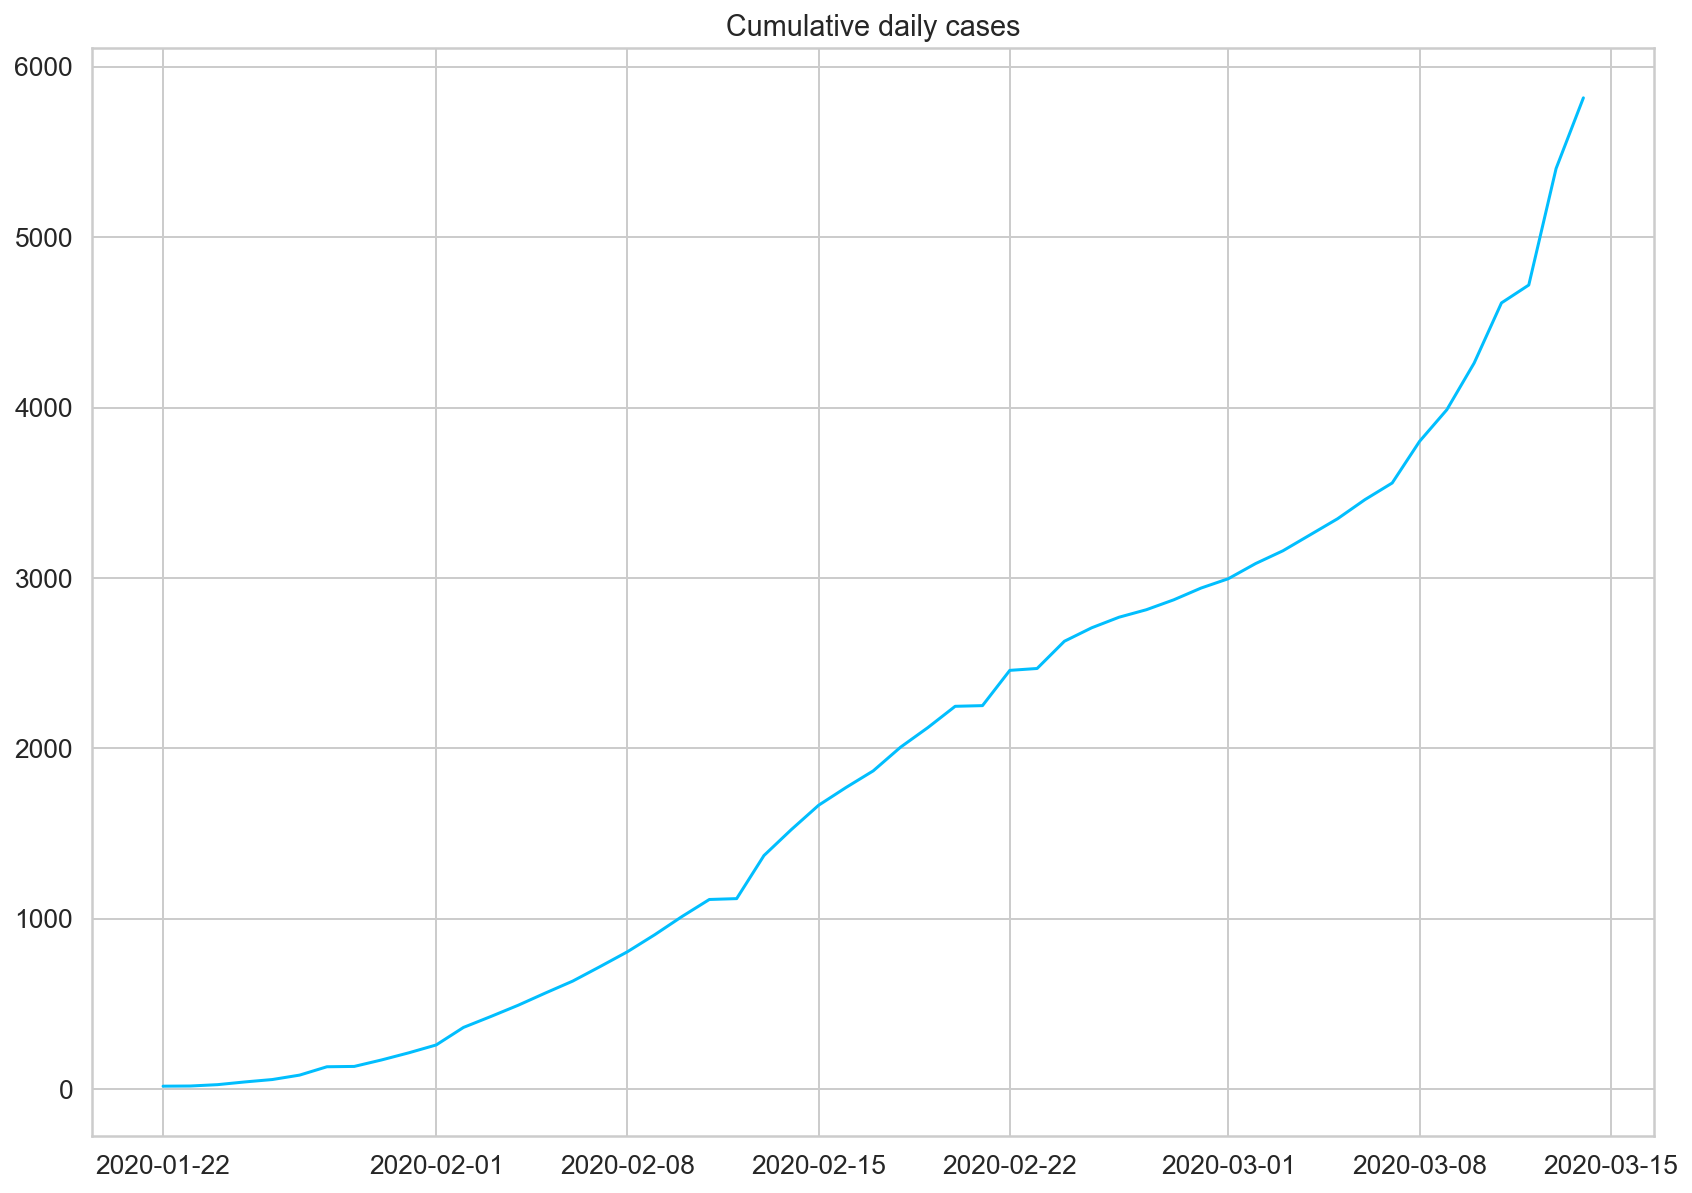

In [995]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases")

In [1049]:
cumulative_cases = daily_cases
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
cumulative_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

Text(0.5, 1.0, 'Daily cases')

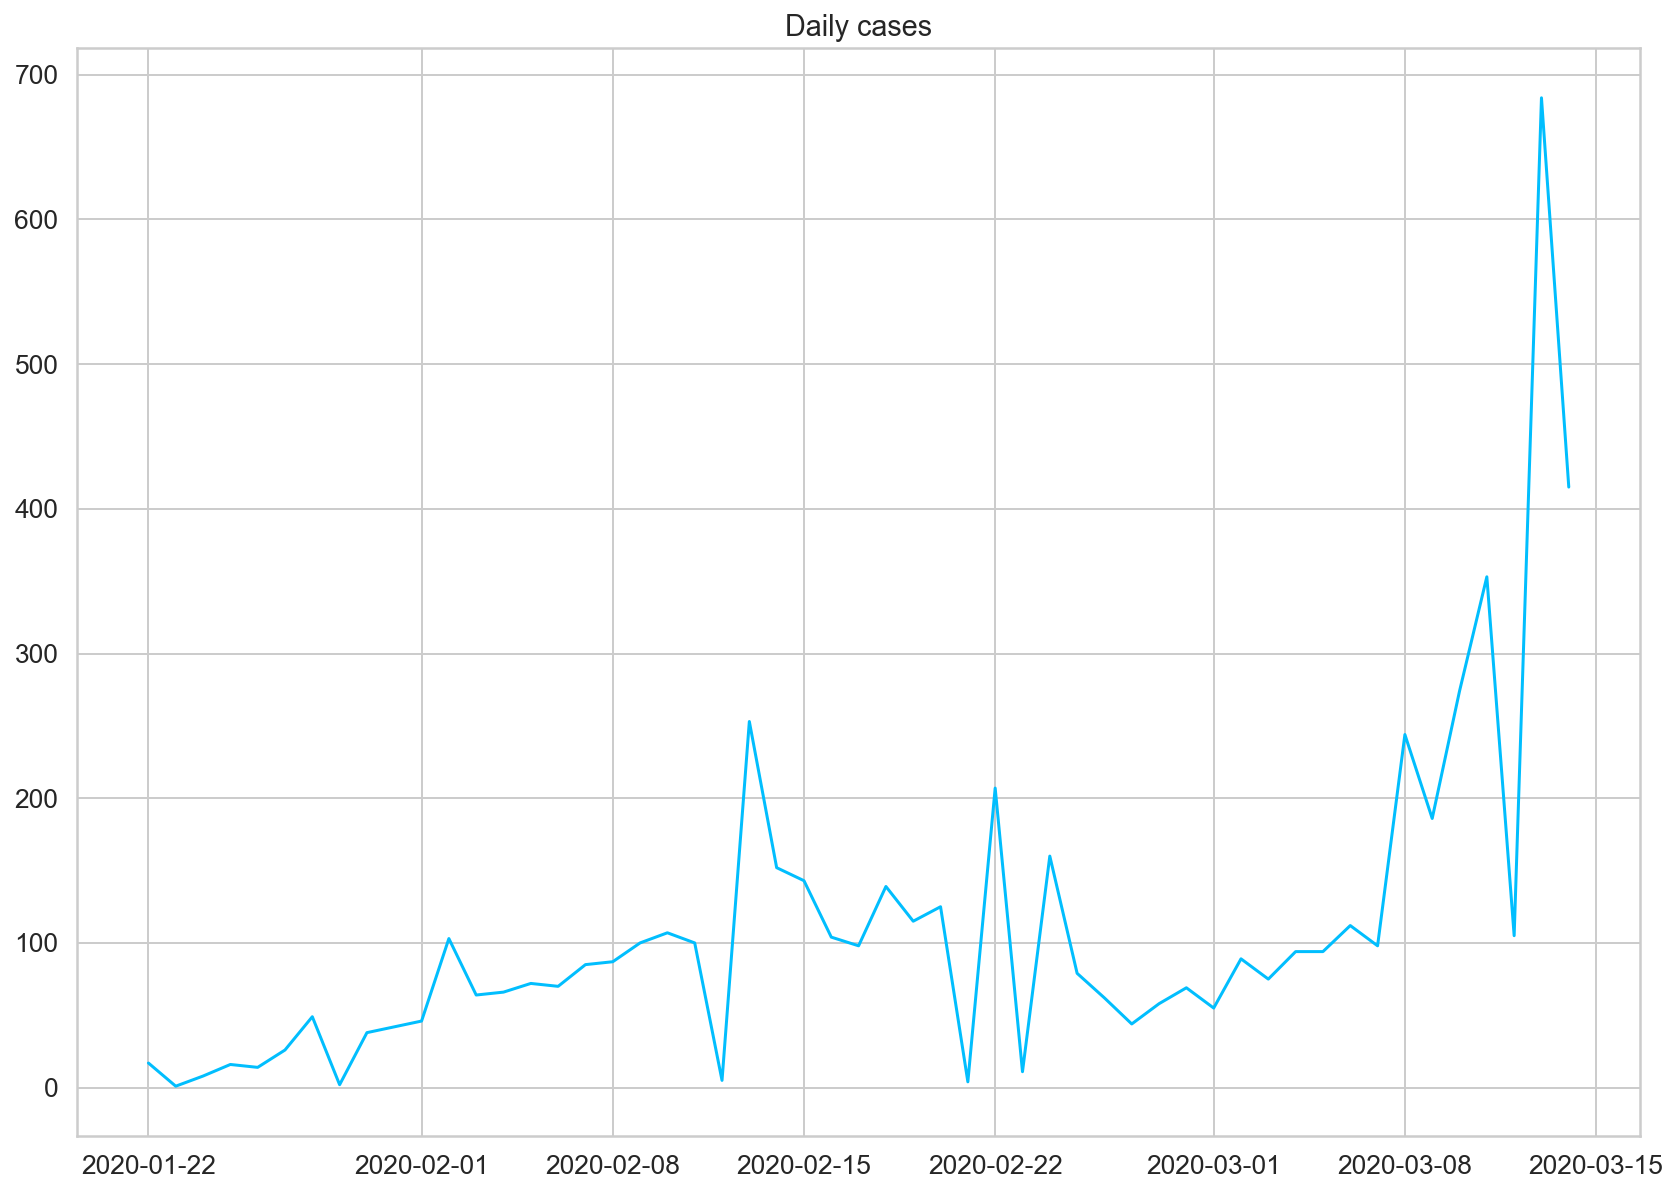

In [997]:
plt.plot(daily_cases)
plt.title("Daily cases")

In [998]:
cumulative_cases.shape

(53,)

In [1017]:
test_data_size = 7

train_data = cumulative_cases[:-test_data_size]
test_data = cumulative_cases[-test_data_size:]

train_data.shape

(46,)

In [1018]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [1019]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [1020]:
seq_length = 3
X_train, y_train = set_seq(train_data, seq_length)
X_test, y_test = set_seq(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [1021]:
X_train.shape

torch.Size([42, 3, 1])

In [1022]:
X_train[:2]

tensor([[[0.0000],
         [0.0003],
         [0.0025]],

        [[0.0003],
         [0.0025],
         [0.0071]]])

In [1023]:
y_train.shape

torch.Size([42, 1])

In [1024]:
y_train[:2]

tensor([[0.0071],
        [0.0110]])

In [1025]:
train_data[:10]

array([[0.        ],
       [0.00028241],
       [0.00254165],
       [0.00706015],
       [0.01101384],
       [0.0183564 ],
       [0.0321943 ],
       [0.03275911],
       [0.04349054],
       [0.0553516 ]])

In [1026]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.3
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [1077]:
def train_model(model, train_data, train_labels, test_data=None,test_labels=None, n_epochs=50):
    
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)
  n_epochs = n_epochs

  train_hist = np.zeros(n_epochs)
  test_hist = np.zeros(n_epochs)

  for t in range(n_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

In [1028]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 14.172311782836914 test loss: 6.113847732543945
Epoch 10 train loss: 9.308340072631836 test loss: 4.92315149307251
Epoch 20 train loss: 4.910699844360352 test loss: 3.3791842460632324
Epoch 30 train loss: 4.40095853805542 test loss: 1.8943642377853394
Epoch 40 train loss: 3.949186086654663 test loss: 2.6156954765319824
Epoch 50 train loss: 3.941030502319336 test loss: 2.600074529647827
Epoch 60 train loss: 3.7908265590667725 test loss: 2.246852159500122
Epoch 70 train loss: 3.7538979053497314 test loss: 2.3138201236724854
Epoch 80 train loss: 3.644693374633789 test loss: 2.3039000034332275
Epoch 90 train loss: 3.5384631156921387 test loss: 2.159986972808838
Epoch 100 train loss: 3.4543802738189697 test loss: 2.1431124210357666
Epoch 110 train loss: 3.1417455673217773 test loss: 1.9308202266693115
Epoch 120 train loss: 2.5406877994537354 test loss: 1.6697251796722412
Epoch 130 train loss: 0.7391310930252075 test loss: 0.5938127040863037
Epoch 140 train loss: 0.365726

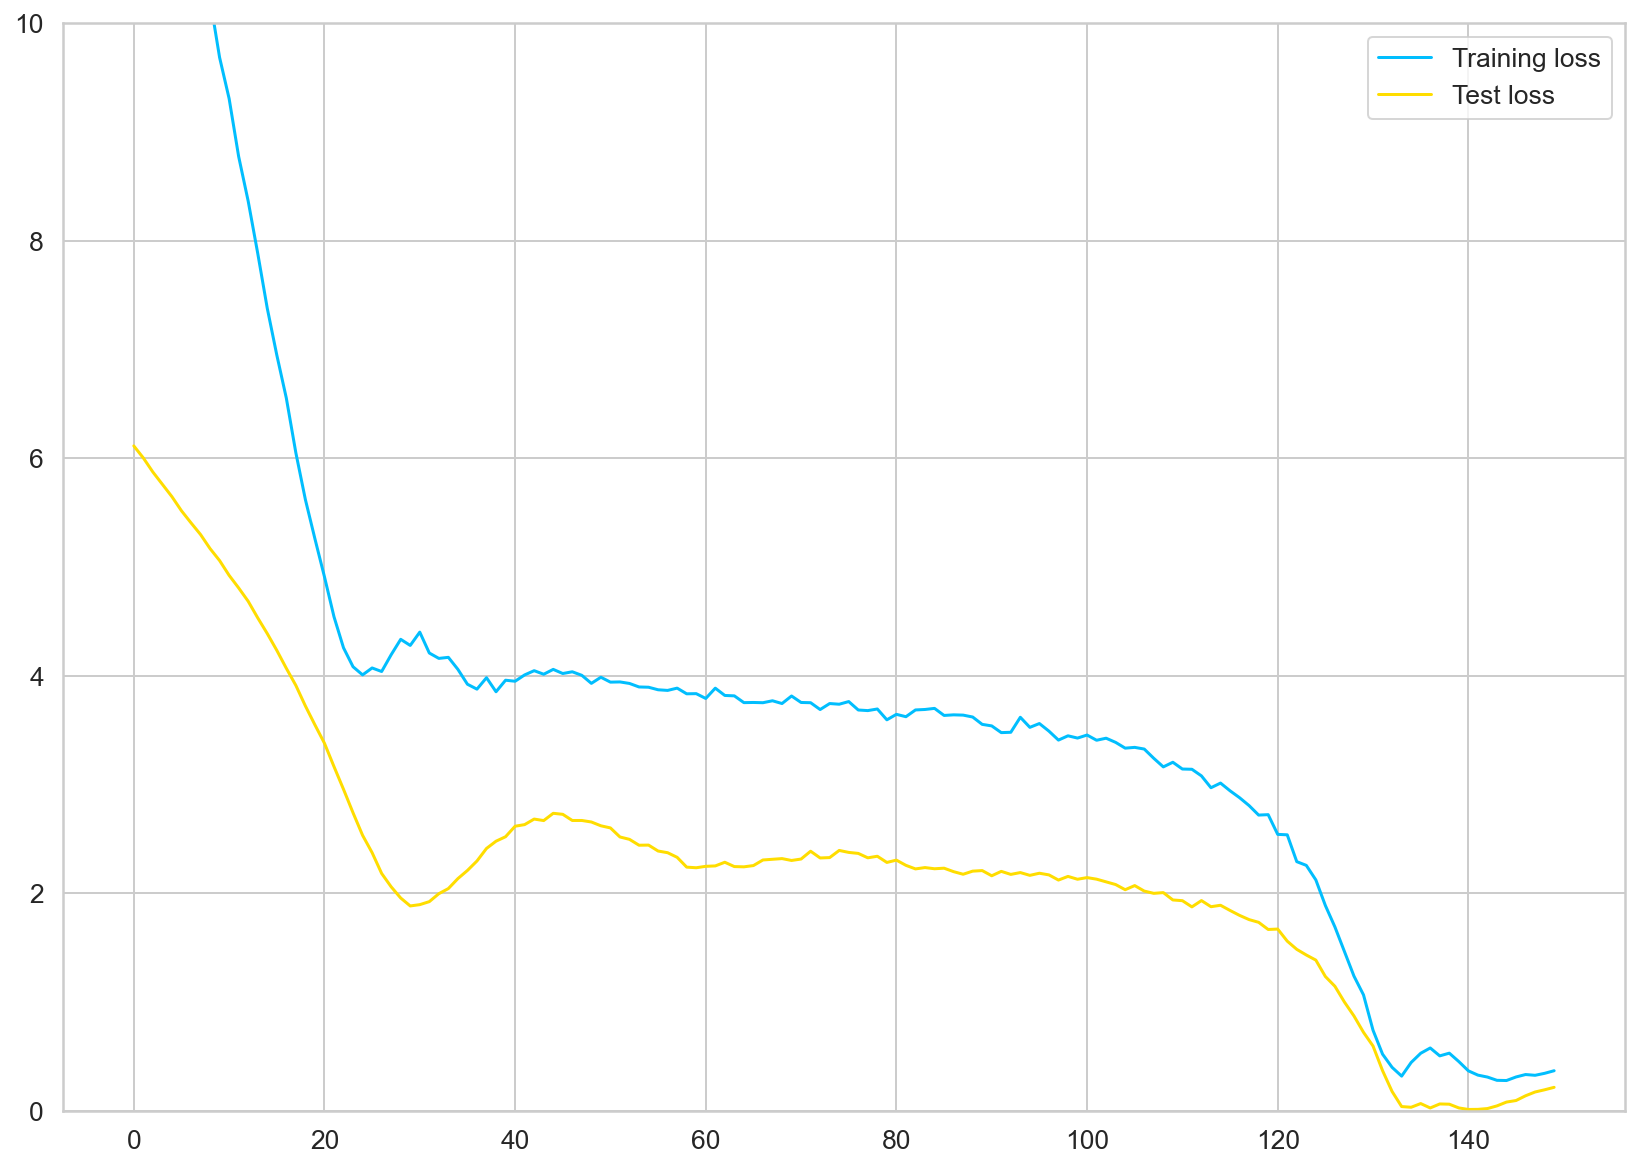

In [1029]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 10))
plt.legend()

In [1030]:
with torch.no_grad():
    test_seq = X_test[:1]
    print(test_seq)
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        print(test_seq)

tensor([[[1.0689],
         [1.1214],
         [1.1988]]])
tensor([[[1.1214],
         [1.1988],
         [1.3112]]])
tensor([[[1.1988],
         [1.3112],
         [1.4036]]])
tensor([[[1.3112],
         [1.4036],
         [1.4966]]])


In [1031]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [1032]:
true_cases

array([4615., 4720., 5404.], dtype=float32)

In [1033]:
predicted_cases

array([4660.06396616, 4987.24925125, 5316.38557541])

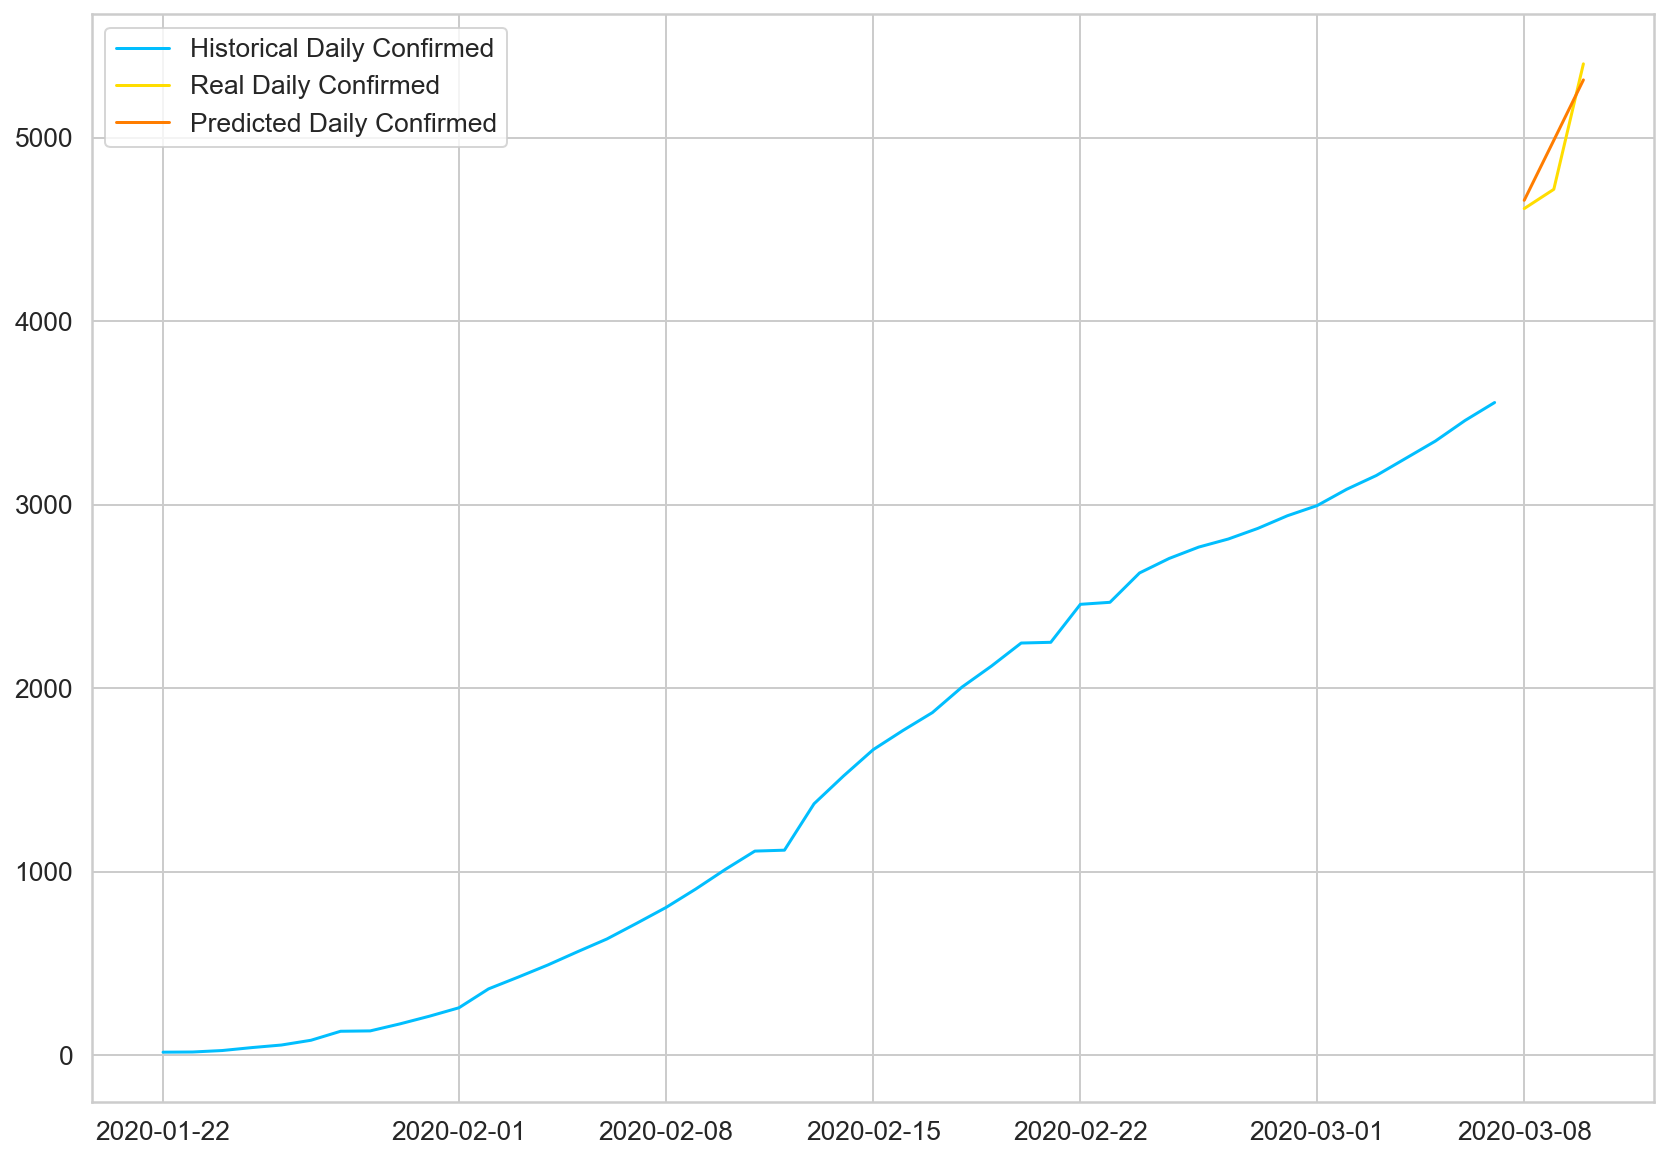

In [1034]:
plt.plot(
  cumulative_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  cumulative_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  cumulative_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

## Confirmed

In [1054]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')

In [1055]:
df = df.iloc[:, 4:]

In [1056]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

In [1057]:
cumulative_cases = daily_cases
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
cumulative_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

Text(0.5, 1.0, 'Cumulative daily cases')

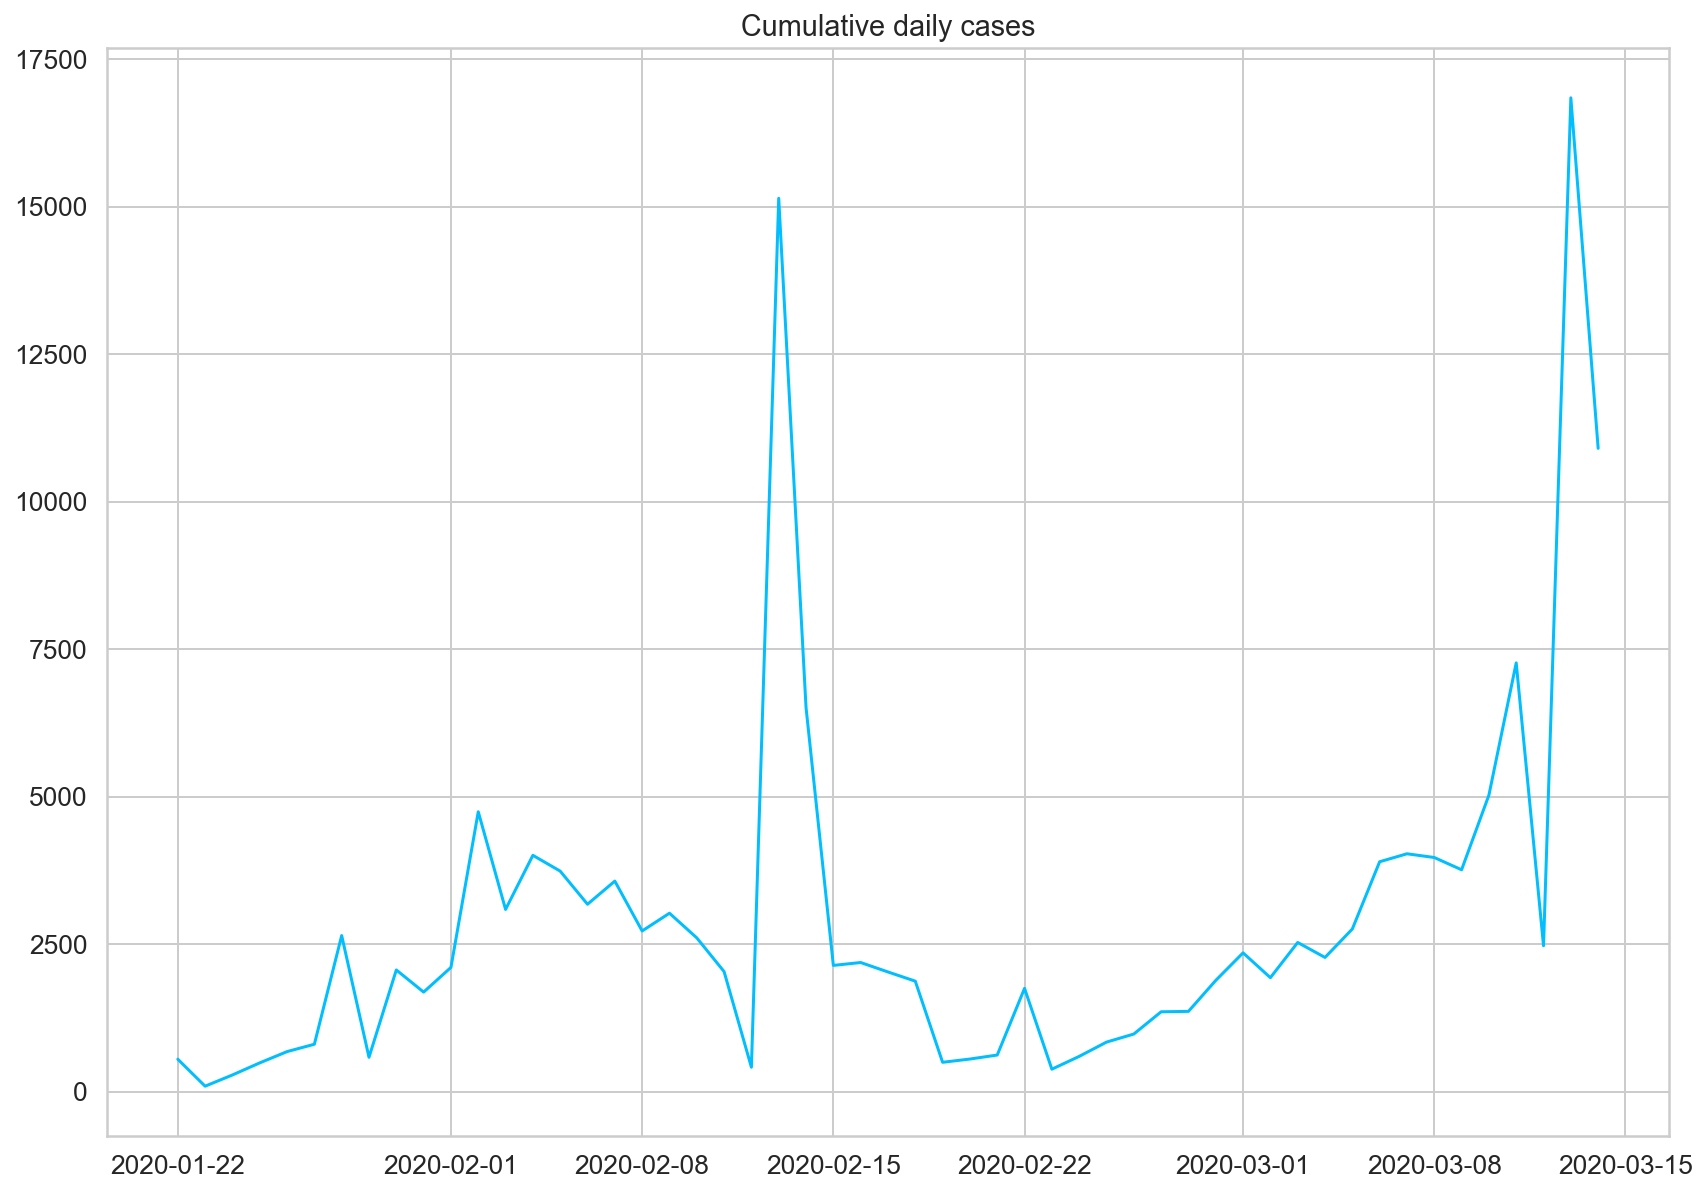

In [1058]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases")

In [1059]:
test_data_size = 7

train_data = cumulative_cases[:-test_data_size]
test_data = cumulative_cases[-test_data_size:]

train_data.shape

(46,)

In [1060]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [1061]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [1062]:
seq_length = 3
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [1086]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test,
    n_epochs=500
)

Epoch 0 train loss: 15.286887168884277 test loss: 4.862613677978516
Epoch 10 train loss: 10.15147590637207 test loss: 3.8714609146118164
Epoch 20 train loss: 5.072874069213867 test loss: 2.507732629776001
Epoch 30 train loss: 4.3399658203125 test loss: 1.1271247863769531
Epoch 40 train loss: 3.885362148284912 test loss: 1.7592428922653198
Epoch 50 train loss: 3.833305835723877 test loss: 1.7623302936553955
Epoch 60 train loss: 3.686668634414673 test loss: 1.4921674728393555
Epoch 70 train loss: 3.721796751022339 test loss: 1.5875359773635864
Epoch 80 train loss: 3.6853861808776855 test loss: 1.579279899597168
Epoch 90 train loss: 3.7238826751708984 test loss: 1.538783073425293
Epoch 100 train loss: 3.6790127754211426 test loss: 1.5531086921691895
Epoch 110 train loss: 3.6448886394500732 test loss: 1.559169888496399
Epoch 120 train loss: 3.603729724884033 test loss: 1.525421380996704
Epoch 130 train loss: 3.5243053436279297 test loss: 1.4692728519439697
Epoch 140 train loss: 3.536406517

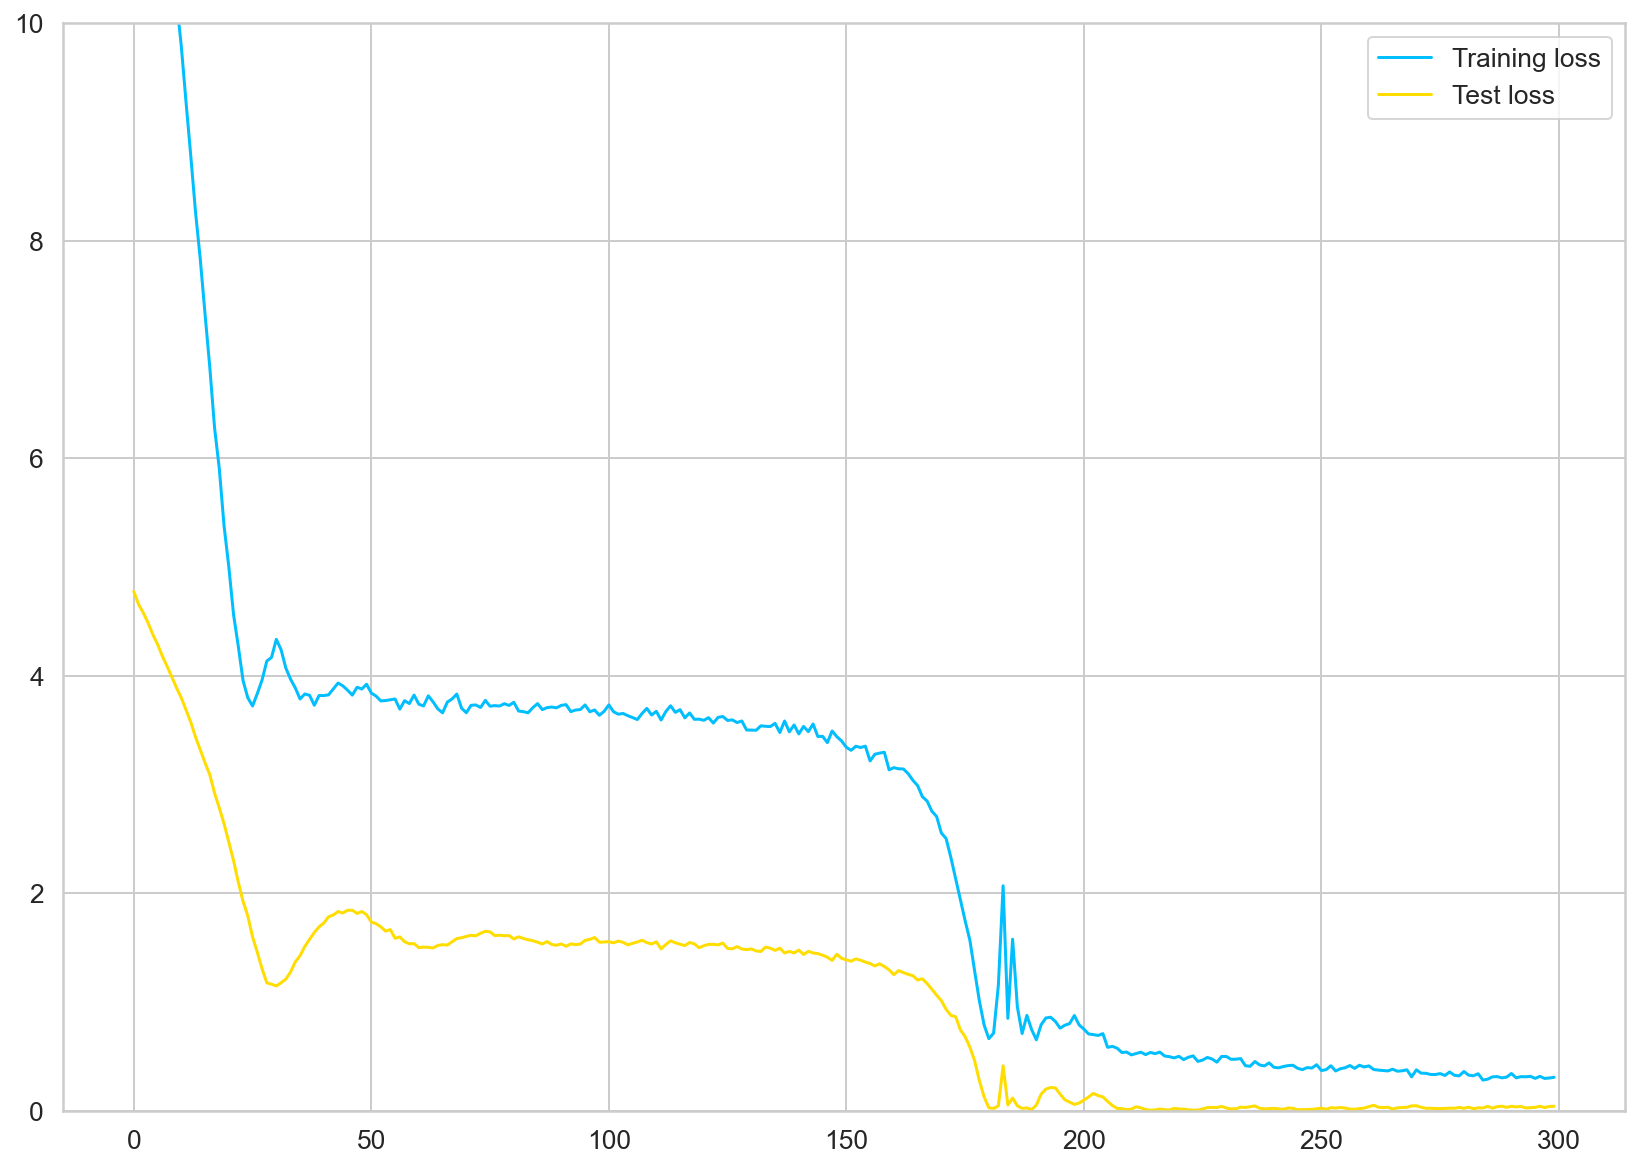

In [1079]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 10))
plt.legend()

In [1080]:
with torch.no_grad():
    test_seq = X_test[:1]
    print(test_seq)
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        print(test_seq)

tensor([[[1.0378],
         [1.0735],
         [1.1213]]])
tensor([[[1.0735],
         [1.1213],
         [1.3018]]])
tensor([[[1.1213],
         [1.3018],
         [1.3763]]])
tensor([[[1.3018],
         [1.3763],
         [1.4506]]])


In [1081]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [1082]:
true_cases

array([125865.01, 128343.01, 145193.  ], dtype=float32)

In [1083]:
predicted_cases

array([137587.65744996, 145435.37921882, 153249.75913143])

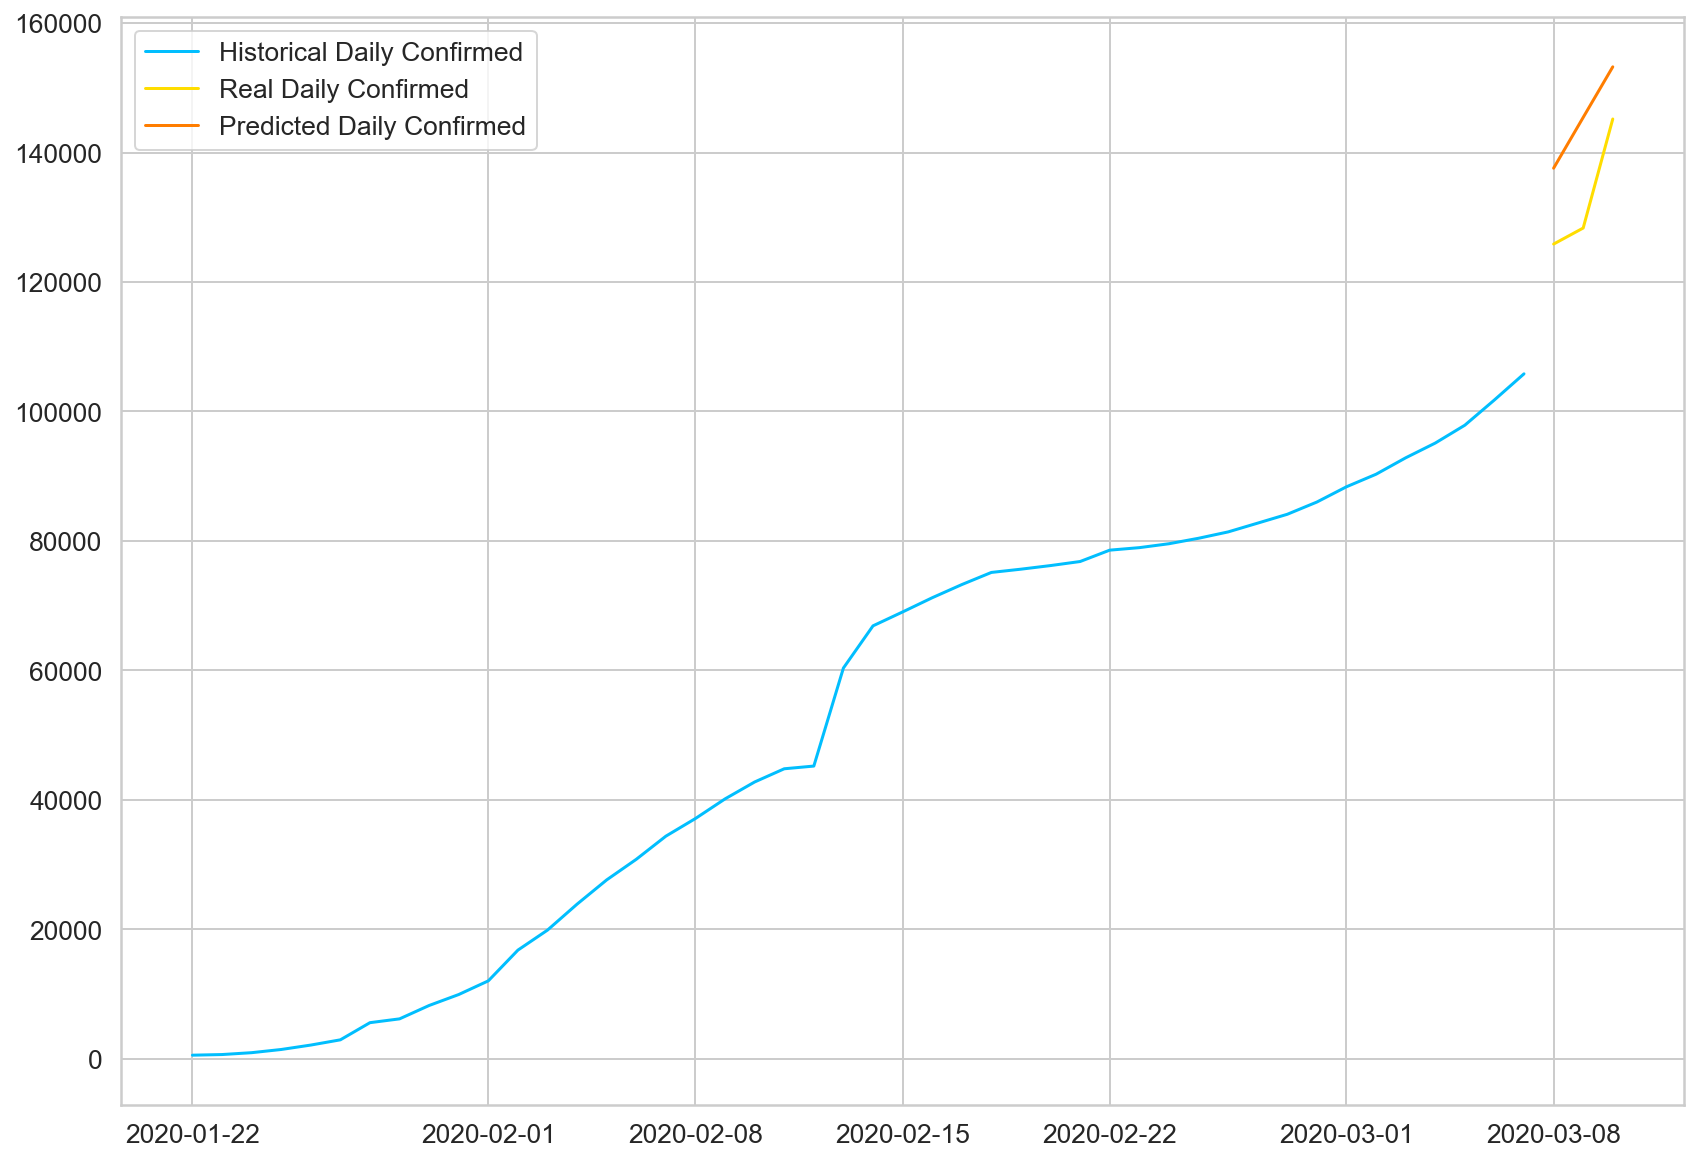

In [1084]:
plt.plot(
  cumulative_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  cumulative_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  cumulative_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()